#### Importing libs and data

In [96]:
import pandas as pd
import seaborn as sns
# Adding the grid lines so the values in the graphs are easier to comprehend 
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import plotly.express as px 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

data= pd.read_csv('WHR_concatenated_with_year.csv')

#### Cleaning data

In [37]:
#check for any NULLs in the data and see data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       1367 non-null   object 
 1   region                        1367 non-null   object 
 2   happiness_score               1367 non-null   float64
 3   gdp_per_capita                1367 non-null   float64
 4   social_support                1367 non-null   float64
 5   healthy_life_expectancy       1366 non-null   float64
 6   freedom_to_make_life_choices  1367 non-null   float64
 7   generosity                    1367 non-null   float64
 8   perceptions_of_corruption     1366 non-null   float64
 9   year                          1367 non-null   int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 106.9+ KB


In [38]:
data.isna().sum()

country                         0
region                          0
happiness_score                 0
gdp_per_capita                  0
social_support                  0
healthy_life_expectancy         1
freedom_to_make_life_choices    0
generosity                      0
perceptions_of_corruption       1
year                            0
dtype: int64

In [39]:
# Fill missing values with the average value
data['perceptions_of_corruption'] = data.groupby('country')['perceptions_of_corruption'].transform(lambda x: x.fillna(x.mean()))
data['healthy_life_expectancy'] = data.groupby('region')['healthy_life_expectancy'].transform(lambda x: x.fillna(x.mean()))

In [40]:
data.isna().sum()

country                         0
region                          0
happiness_score                 0
gdp_per_capita                  0
social_support                  0
healthy_life_expectancy         0
freedom_to_make_life_choices    0
generosity                      0
perceptions_of_corruption       0
year                            0
dtype: int64

### Корреляционный анализ

С помощью теста Пирсона

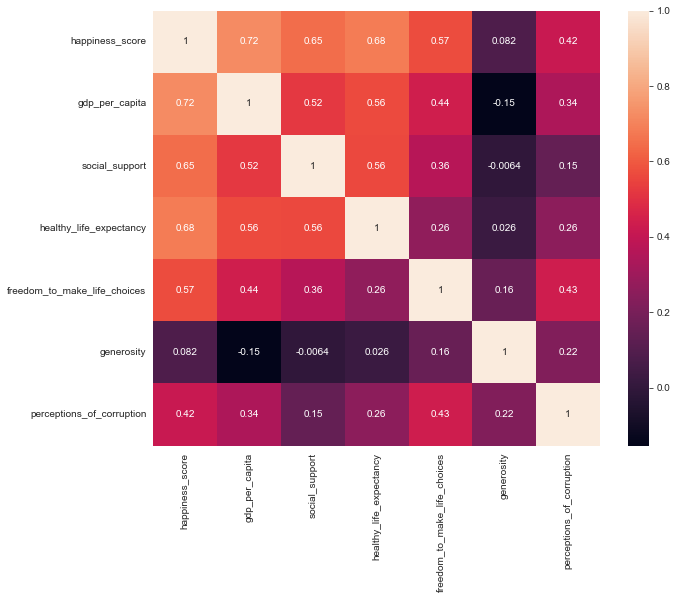

In [100]:
data_num = data.select_dtypes('number')
data_num = data_num.drop(['year'], axis=1)
corr = data_num.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True)
plt.show()

С помощью теста Спирмана

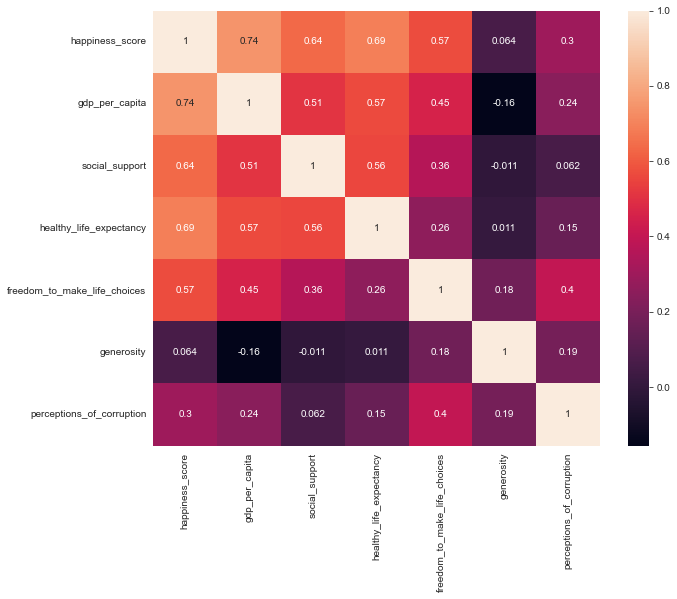

In [102]:
data_num = data.select_dtypes('number')
data_num = data_num.drop(['year'], axis=1)
corr = data_num.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True)
plt.show()

С помощью ранговой корреляции Кендалла

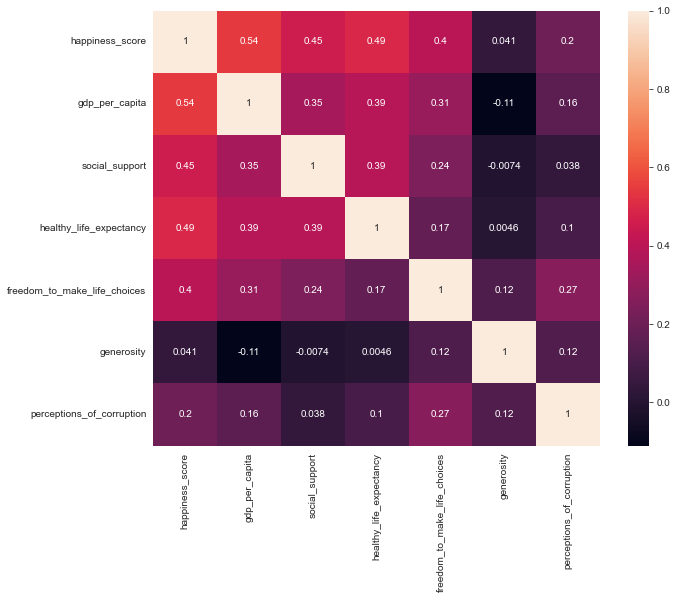

In [104]:
data_num = data.select_dtypes('number')
data_num = data_num.drop(['year'], axis=1)
corr = data_num.corr(method='kendall')

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True)
plt.show()

При анализе корреляции в случаях всех тестов выявлена положительная корреляция между ВВП на душу населения и показателем счастья. Кроме того, обращает на себя внимание отрицательная корреляция между щедростью и ВВП на душу населения и социальной поддержкой. Хочется заметить, что тест Пирсона предназначен для данных, распределенных нормально. А мы в прошлом домашнем задании проверили, что данные распределены НЕ нормально, но близко к нормальному (было смещение хвоста). Тесты Кендала и Спирмана оба являются непараметрическими, отличаются размером выборки. В случае наших данных тест Спирмана сильнее выявил связь корреляцию ВВП и счастьем, щедростью и ВВП на душу населения и социальной поддержкой.

Графическое представление корреляции

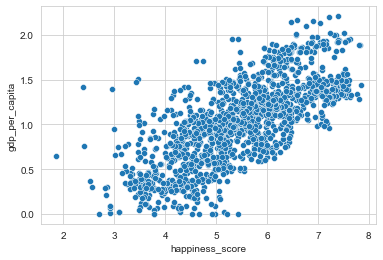

In [106]:
sns.scatterplot(x="happiness_score", y="gdp_per_capita", data=data);

Корреляция между ввп страны и показателем счастья ее населения выглядит действительно близкой к 0,74 и явно больше чем 0,54, что дал тест Кендалла. Данная корреляция вполне имеет смысл: с ростом ввп растет качество жизни людей, что делает их более счастливыми.

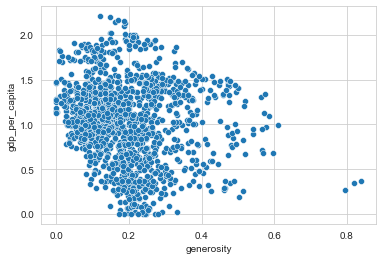

In [91]:
sns.scatterplot(x="generosity", y="gdp_per_capita", data=data);

Корреляция между ввп страны и показателем щедрости ее населения выглядит действительно отрицательной и близкой к нулю. Ясно объяснить смысл данной корреляции мне не удалось.

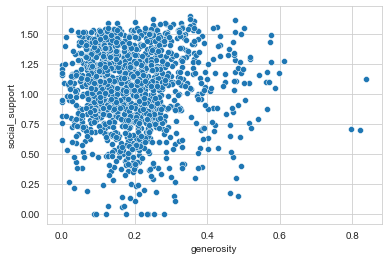

In [107]:
sns.scatterplot(x="generosity", y="social_support", data=data);

Корреляция между социальной поддержкой, которую ощущает население, и показателем щедрости ее населения выглядит действительно отрицательной и близкой к нулю. По моему мнению, в данном случае корреляция должна была быть положительной. В данном опросе респонденты отвечают на вопрос «Если вы попали в беду, есть ли у вас родственники или друзья, на помощь которых вы можете рассчитывать, когда они вам понадобятся, или нет?» Ответы записываются как "Нет" (0) или "Да". Кажется, что при более щедром население должно было быть больше положительных ответов.

### Прогноз на основании данных

Рассмотрим 2 варианта:
1. Предсказание показателя счастья в странах в следующем календарном году
2. Предсказание показателя счастья в старанах, где мы не знаем показатель счастья, по значениям этого показателя в других странах, где мы его знаем

#### 1. Предсказание показателя счастья в странах в следующем календарном году

In [41]:
X_train = data[data["year"] != 2023]
X_test = data[data["year"] == 2023]

In [42]:
X_train.shape, X_test.shape

((1230, 10), (137, 10))

In [43]:
numeric_features = ["gdp_per_capita", "social_support", "healthy_life_expectancy", 
                    "freedom_to_make_life_choices", "generosity", "perceptions_of_corruption"]
numeric_transformer = StandardScaler()

categorical_features = ["region"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="first")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [44]:
preprocessor.fit(X_train)
x_train = preprocessor.transform(X_train)
x_test = preprocessor.transform(X_test)

y_train = X_train["happiness_score"]
y_test = X_test["happiness_score"]

In [45]:
x_train.shape

(1230, 16)

In [46]:
reg = LinearRegression().fit(x_train, y_train)
preds = reg.predict(x_test)

In [47]:
print(f"MAE = {round(mean_absolute_error(y_test, preds), 2)}")
print(f"MAPE = {round(mean_absolute_percentage_error(y_test, preds), 2)}")

MAE = 0.41
MAPE = 0.09


<AxesSubplot:xlabel='happiness_score', ylabel='Count'>

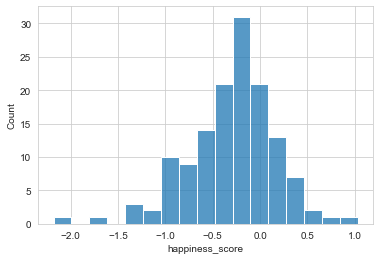

In [49]:
sns.histplot(y_test - preds)

Из распределения ошибки видно, что наша модель перепредсказывает (распределение симметричное, но сдвинуто влево). Это может означать, что в 2023 году страны, с таким же показателем как и раньше, стали менее счастливыми.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


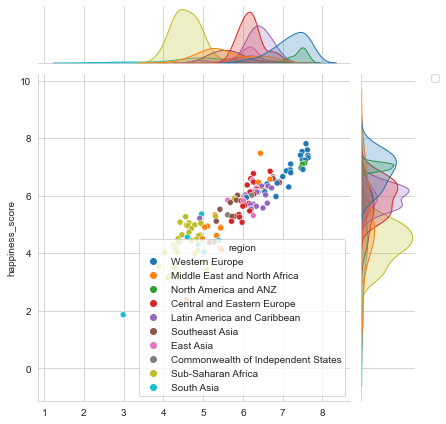

In [51]:
ax = sns.jointplot(data=X_test, x=preds, y="happiness_score", hue="region")
plt.legend(bbox_to_anchor=(1.3, 1), loc=2, borderaxespad=0.)

Видно, что прогноз ошибается больше всего в регионе Sub-Saharan Africa (не лежит на прямой х=у)

#### 2. Предсказание показатель счастья в старанах, где мы не знаем показатель счастья, по значениям этого показателя в других странах, где мы его знаем

In [52]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1093, 10), (274, 10))

In [53]:
numeric_features = ["gdp_per_capita", "social_support", "healthy_life_expectancy", 
                    "freedom_to_make_life_choices", "generosity", "perceptions_of_corruption"]
numeric_transformer = StandardScaler()

categorical_features = ["region"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="first")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [54]:
preprocessor.fit(X_train)
x_train = preprocessor.transform(X_train)
x_test = preprocessor.transform(X_test)

y_train = X_train["happiness_score"]
y_test = X_test["happiness_score"]

In [55]:
x_train.shape

(1093, 16)

In [56]:
reg = LinearRegression().fit(x_train, y_train)
preds = reg.predict(x_test)

In [57]:
print(f"MAE = {round(mean_absolute_error(y_test, preds), 2)}")
print(f"MAPE = {round(mean_absolute_percentage_error(y_test, preds), 2)}")

MAE = 0.4
MAPE = 0.08


<AxesSubplot:xlabel='happiness_score', ylabel='Count'>

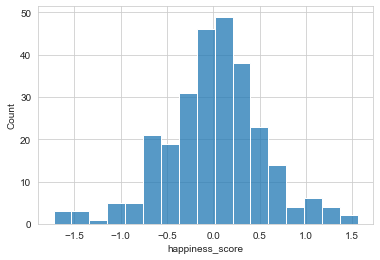

In [58]:
sns.histplot(y_test - preds)

В данном случае, распределение полностью симметричное. Проблем с предсказанием нет. Это было ожидаемо, поскольку мы взяли в тест все года